In [61]:
import sys
import os

# Get the absolute path to the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
from chatbot_api.providers.openai import OpenAIProvider
from chatbot_api.base import EmbeddingResponse, Message, Role
from dotenv import load_dotenv
from pathlib import Path

# Load environment variables
env_path = Path.cwd().parent / ".env"  # move up one directory to find the .env file
success = load_dotenv(dotenv_path=env_path, override=True)
key = os.getenv("OPENAI_API_KEY")

# config
n_comments = 500
response_max_tokens = 100
data_source_path = os.path.join(parent_dir, 'data', 'sources', 'kuntavaalit2021.csv')
plot_output_path = os.path.join('results', 'cluster_plot.png')
question_columns = ['q1.explanation_fi', 'q2.explanation_fi']
provider = OpenAIProvider(api_key=os.getenv("OPENAI_API_KEY"))
eps = 0.7
min_samples = 10

In [62]:

# Load the open comments from CSV
def load_statements(file_path: str) -> List[str]:
    df = pd.read_csv(file_path)
    return df[question_columns[1]].dropna()[:n_comments].tolist()

# Get embeddings for the political statements
async def get_embeddings_for_statements(statements: List[str]) -> List[EmbeddingResponse]:
    embeddings_responses = await provider.get_embeddings(statements)
    print(embeddings_responses[:10])
    return embeddings_responses

from typing import List, Dict, Tuple
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from torch import pdist
import torch

def cluster_messages(statements: List[str], embeddings_responses: List[EmbeddingResponse], 
                    eps: float = 0.8, min_samples: int = 2) -> Tuple[Dict[int, List[str]], np.ndarray, np.ndarray]:
    # Extract embeddings from responses
    embeddings = np.array([response.embedding for response in embeddings_responses])
    
    # Normalize to unit length instead of standardizing
    embeddings_normalized = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]
    
    # Calculate some distance statistics to help tune eps
    distances = pdist(torch.tensor(embeddings_normalized)).numpy()
    print(f"Distance statistics for normalized embeddings:")
    print(f"Min distance: {np.min(distances):.3f}")
    print(f"Max distance: {np.max(distances):.3f}")
    print(f"Mean distance: {np.mean(distances):.3f}")
    print(f"Median distance: {np.median(distances):.3f}")
    
    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(embeddings_normalized)
    
    # Print clustering results
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"\nClustering results with eps={eps}:")
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    print(f"Percentage of points clustered: {(1 - n_noise/len(labels))*100:.1f}%")
    
    # Group statements by cluster label
    clustered_statements = {}
    for idx, label in enumerate(labels):
        if label not in clustered_statements:
            clustered_statements[label] = []
        clustered_statements[label].append(statements[idx])
    
    return clustered_statements, labels, embeddings

def get_cluster_statistics(labels: np.ndarray) -> Dict:
    """
    Calculate statistics about the clustering results.
    
    Args:
        labels: Array of cluster labels from DBSCAN
    
    Returns:
        Dictionary containing clustering statistics
    """
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    cluster_sizes = {label: list(labels).count(label) 
                    for label in set(labels) if label != -1}
    
    return {
        'num_clusters': n_clusters,
        'num_noise_points': n_noise,
        'cluster_sizes': cluster_sizes,
        'total_points': len(labels)
    }

In [63]:
# Generate a summary for each cluster
async def summarize_cluster(statements: List[str]) -> str:
    prompt = (
        "The following are arguments from a cluster. Summarize them into a single representative statement:\n\n" +
        "\n".join(f"- {s}" for s in statements) +
        "\n\nSummarize these in one concise statement, distilling the essential message in the way that it is relevant to political decisions:"
    )
    
    messages = [Message(role=Role("user"), content=prompt)]
    response = await provider.generate(messages, temperature=0.7, max_tokens=response_max_tokens)
    return response.content

def display_cluster_details(clustered_messages: dict, cluster_summaries: dict):
    """
    Display the original statements for each cluster alongside their summary.
    
    Args:
        clustered_messages (dict): Dictionary mapping cluster IDs to lists of original statements
        cluster_summaries (dict): Dictionary mapping cluster IDs to cluster summaries
    """
    for cluster_id in sorted(clustered_messages.keys()):
        print(f"\n{'='*80}")
        print(f"Cluster {cluster_id}")
        print(f"{'='*80}")
        
        # Print the summary
        print("\nCluster Summary:")
        print(f"{cluster_summaries[cluster_id]}")
        
        # Print all original statements
        print("\nOriginal Statements:")
        for idx, statement in enumerate(clustered_messages[cluster_id], 1):
            print(f"\n{idx}. {statement}")
        
        print(f"\nTotal statements in cluster: {len(clustered_messages[cluster_id])}")
        print(f"{'='*80}\n")

def visualize_clusters(embeddings: np.ndarray, labels: np.ndarray, n_clusters: int):
    # PCA transforms our high-dimensional embeddings into 2D space
    # Think of it as finding the most informative "camera angles" to view our data
    pca = PCA(n_components=2, random_state=42)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    # Calculate how much information we preserved in our 2D projection
    # This is like measuring how accurate our "shadow" is compared to the original object
    explained_variance_ratios = pca.explained_variance_ratio_ * 100
    cumulative_variance = np.cumsum(explained_variance_ratios)
    
    # Create two subplots: one for visualizing clusters, one for explaining variance
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), height_ratios=[2, 1])
    
    # First plot: Shows how the political statements cluster in 2D space
    # Each point represents one statement, colored by its cluster
    cluster_df = pd.DataFrame({
        'x': reduced_embeddings[:, 0],  # First principal component
        'y': reduced_embeddings[:, 1],  # Second principal component
        'cluster': labels
    })
    
    # Create the scatter plot with points colored by cluster
    sns.scatterplot(
        data=cluster_df,
        x='x', y='y',
        hue='cluster',
        palette=sns.color_palette('hsv', n_clusters),
        legend='full',
        ax=ax1
    )
    
    # Label axes with the amount of variance they explain
    # This tells us how much information each dimension captures
    ax1.set_title('Clusters of Political Statements (2D Visualization)')
    ax1.set_xlabel(f'PCA Dimension 1 ({explained_variance_ratios[0]:.1f}% variance explained)')
    ax1.set_ylabel(f'PCA Dimension 2 ({explained_variance_ratios[1]:.1f}% variance explained)')
    ax1.legend(title='Cluster')
    
    # Second plot: Shows how much information we preserved
    # This helps us understand the quality of our 2D representation
    components = range(1, 3)
    
    # Blue bars show individual contribution of each component
    ax2.bar(components, explained_variance_ratios, alpha=0.5, color='b', label='Individual')
    
    # Red line shows cumulative information preserved
    ax2.plot(components, cumulative_variance, 'r-o', label='Cumulative')
    ax2.set_title('Explained Variance by Principal Components')
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Explained Variance (%)')
    ax2.set_xticks(components)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add an annotation showing total information preserved
    total_variance = cumulative_variance[-1]
    ax2.text(0.95, 0.95, 
             f'Total variance explained: {total_variance:.1f}%',
             transform=ax2.transAxes,
             horizontalalignment='right',
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(plot_output_path, dpi=300, bbox_inches='tight')
    
    # Print detailed information about information preservation
    print("\nPCA Variance Explanation:")
    print(f"{'='*50}")
    print(f"PC1 explains {explained_variance_ratios[0]:.1f}% of the variance")
    print(f"PC2 explains {explained_variance_ratios[1]:.1f}% of the variance")
    print(f"Total variance explained: {total_variance:.1f}%")
    print(f"{'='*50}")
    
    print(f"\nCluster visualization saved to {plot_output_path}")

[EmbeddingResponse(embedding=array([0.0152756 , 0.03137096, 0.03361032, ..., 0.02377315, 0.01402596,
       0.00731289], dtype=float32), tokens=82, model='text-embedding-3-small'), EmbeddingResponse(embedding=array([-0.05042229,  0.04227563,  0.04488572, ...,  0.01745007,
        0.01290217,  0.00590237], dtype=float32), tokens=82, model='text-embedding-3-small'), EmbeddingResponse(embedding=array([ 0.00405296,  0.01261031,  0.09072276, ..., -0.00351719,
        0.00770905,  0.04702821], dtype=float32), tokens=82, model='text-embedding-3-small'), EmbeddingResponse(embedding=array([ 0.01266587,  0.02570185,  0.0730755 , ..., -0.02115776,
        0.01489679,  0.03287781], dtype=float32), tokens=82, model='text-embedding-3-small'), EmbeddingResponse(embedding=array([ 0.01444087,  0.05034326,  0.05403433, ...,  0.00108211,
       -0.00617399,  0.01091151], dtype=float32), tokens=82, model='text-embedding-3-small'), EmbeddingResponse(embedding=array([-0.0618645 ,  0.02142385, -0.02034558, .

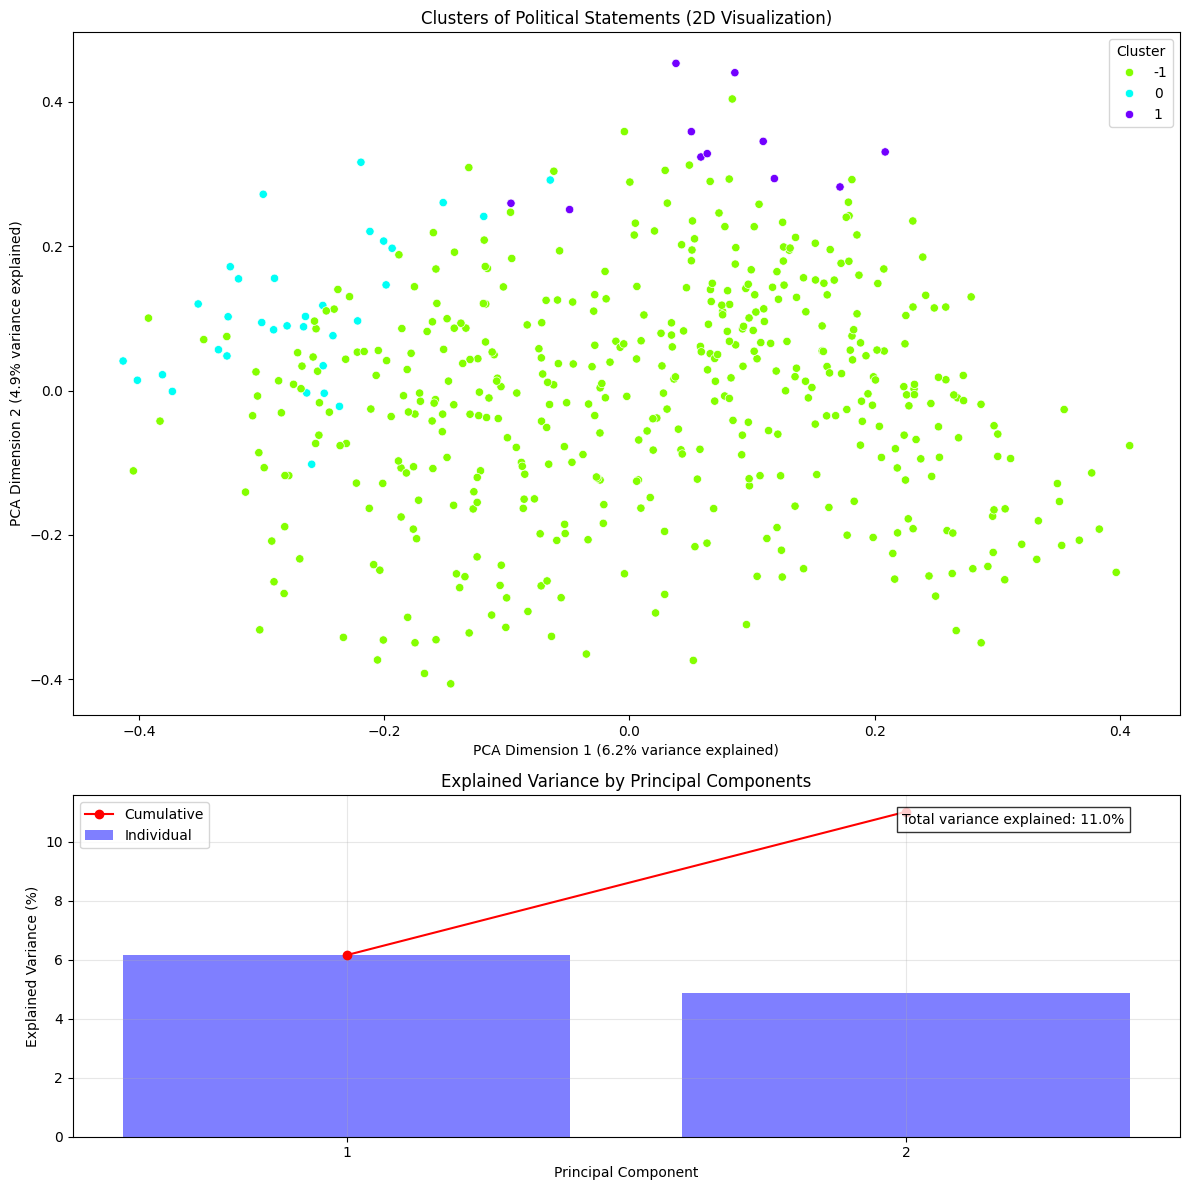

In [64]:
async def main():
    # Load the statements from CSV
    statements = load_statements(data_source_path)
    
    # Get embeddings for each statement
    embeddings_responses = await get_embeddings_for_statements(statements)

    # Cluster the statements based on their embeddings
    clustered_messages, labels, embeddings = cluster_messages(statements, embeddings_responses, eps=eps, min_samples=min_samples)

    # Generate summaries for each cluster
    cluster_summaries = {}
    for cluster_id, cluster_statements in clustered_messages.items():
        # if cluster_id == -1: # skip noise points
        #     continue
        print(f"Summarizing Cluster {cluster_id}...")
        cluster_summaries[cluster_id] = await summarize_cluster(cluster_statements)
    
    # Display cluster details
    display_cluster_details(clustered_messages, cluster_summaries)

    # Visualize
    print("Visualizing clusters...")
    visualize_clusters(embeddings, labels, n_clusters=len(set(labels)))

# Run the script
await main() # for 500 comments: 1 minute